## Text Classification with BERT




In [1]:
### Instalando as dependências necessárias
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip install transformers
# # ! pip install torchviz
# ! pip install scikit-learn
# ! pip install ipywidgets
# Tratamento de dados
# ! pip install -U pip setuptools wheel
# ! pip install -U 'spacy'
# ! python -m spacy download en_core_web_sm

In [1]:
import re
import spacy
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [175]:
# Name do modelo de classificação a ser baixado

MODEL_CLASSIFICATION_NAME= "D:/tcc2/guilherme/1_Study_Cases/saved_models/BinaryClassificationModel_IMDB_dataset_origin.pth"


### Baixar CSV DAtaset

Caso você queira executar o modelo no colab, você deve baixar o conjunto de dados do IMDB no link abaixo e adiciona-lo a raiz do seu projeto:

<a href="https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" target="_blank">Conjunto de dados IMDB de 50 mil críticas de filmes</a>


In [3]:
def load_imdb_data(data_path):
    df = pd.read_csv(data_path)
    df["sentiment"] = [
        1 if sentiment == "positive" else 0 for sentiment in df["sentiment"].tolist()
    ]
    return df

In [4]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["sentiment"].tolist()
    return texts, labels

In [5]:
DATA_PATH = "D:/tcc2/guilherme/1_Study_Cases/data/IMDB Dataset.csv"
df = load_imdb_data(DATA_PATH)


In [6]:
df.duplicated().sum()

418

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df["review"].size

49582

In [9]:
def maior_text(texts):
    return max(texts, key=lambda x: len(x.split()))

In [10]:
texts, labels = load_texts_labels(df)
maior_string = maior_text(texts)
tam_maior_string = len(maior_string)
print(tam_maior_string)

13704


In [12]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label),
        }

In [15]:
# original com funcoes de ativacao relu

class MultiClassClassifier(nn.Module):
    def __init__(self, bert_model_name: str, hidden_size: int, num_classes: int):
        super(MultiClassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs_bert.pooler_output
        drop = F.relu(self.dropout(pooled_output))
        logits = F.relu(self.linear1(drop))
        logits = F.relu(self.linear2(logits))

        return logits

In [16]:
def train_model_epoch(
    model: MultiClassClassifier, data_loader, optimizer, scheduler, loss_func, device
):
    model.train()
    losses = []
    model_prediction = []
    actual_labels = []
    for batch in tqdm(data_loader, colour="green", desc="Train_epoch: "):
    
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_func(outputs, labels)
        loss.backward()
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        model_prediction.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        optimizer.step()
        scheduler.step()

    train_accuracy = accuracy_score(actual_labels, model_prediction)
    train_loss = np.mean(losses)


    return train_accuracy, train_loss

In [17]:
def eval_model_epoch(
    model: MultiClassClassifier, data_loader: TextClassificationDataset,loss_func, device: str
):
    model.eval()
    losses = []
    model_prediction = []
    actual_labels = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, colour="blue", desc="Validation_epoch: "):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            model_prediction.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            correct_predictions += torch.sum(preds == labels)
            loss = loss_func(outputs, labels)
            losses.append(loss.item())
    val_losses = np.mean(losses)
    val_accuracies = accuracy_score(actual_labels, model_prediction)
    report = classification_report(actual_labels, model_prediction,output_dict=True)
    return (val_accuracies, val_losses, report)

In [18]:
# Set up parameters
BERT_MODEL_NAME = "bert-base-uncased"
hidden_size = 10  # Tamanho camada oculto, neuronios antes da saída
num_outputs = 3  # numero de classes de saída [negativo,neutro, positivo]
max_length = 256  # 128,256,512 (tamanho do texto a ser tokenizado vetorizado)
batch_size = 8  # 8, 16, 32 (tamanho do lote na iteracao, treinamento e classe)
num_epochs = 10  # recomend in the Bert Article [2,3,4]
learning_rate = 2e-5  # Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5

In [20]:
# temp_texts e temp_labels são variáveis usadas 
# para separar o dataset de validação e treinamento
# Sem perder a vantagem da função train_text_split
# definindo train_data como 70% dos dados
# definindo temp_text como 30% dos dados
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)

# define validatin_data and test_data 
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [21]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


d:\tcc2\guilherme\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
# Creating personalized dataset train,eval and test
train_dataset = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset= TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)

# creating iterator data_loader train, eval and test
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_outputs).to(device)


cuda


d:\tcc2\guilherme\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
loss_func = nn.CrossEntropyLoss().to(device)

## Fit model

on ocours epoch  training and validation epochs and adjustment weight models

In [ ]:
history = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
    "val_reports": [],
}

best_accuracy = 0
epochs_without_improvements = 0


In [143]:
# Foi executado até chegar em 10 épocas para demonstrar o overfiting 
# as informações estão no gráfico de perda e de acuracia
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{1}")
    print("-" * 50)
    # Treinamento
    train_accuracy, train_loss = train_model_epoch(
        model, train_dataloader, optimizer, scheduler, loss_func, device
    )
    # Validation
    val_accuracy, val_loss, report = eval_model_epoch(
        model, val_dataloader, loss_func, device
    )

    history["train_losses"].append(train_loss)
    history["train_accuracies"].append(train_accuracy)
    history["val_losses"].append(val_loss)
    history["val_accuracies"].append(val_accuracy)
    history["val_reports"].append(report)
    print(f"Train => Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")
    print(f"Validation => Loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}")
    print(report)
    print()
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), MODEL_CLASSIFICATION_NAME)
        epochs_without_improvements = 0
        best_accuracy = val_accuracy
    else:
        epochs_without_improvements += 1

    if epochs_without_improvements > 4:
        break

Epoch 1/1
--------------------------------------------------


Validation_epoch: 100%|██████████| 930/930 [02:14<00:00,  6.91it/s]

Train => Loss = 0.0272, Accuracy = 0.9954
Validation => Loss = 0.2852, Accuracy = 0.9269
{'0': {'precision': 0.9305029745808545, 'recall': 0.9230150214592274, 'f1-score': 0.9267438728790736, 'support': 3728.0}, '1': {'precision': 0.9232415084247125, 'recall': 0.93070908600701, 'f1-score': 0.9269602577873255, 'support': 3709.0}, 'accuracy': 0.926852225359688, 'macro avg': {'precision': 0.9268722415027835, 'recall': 0.9268620537331187, 'f1-score': 0.9268520653331995, 'support': 7437.0}, 'weighted avg': {'precision': 0.9268815172764132, 'recall': 0.926852225359688, 'f1-score': 0.9268517889238103, 'support': 7437.0}}



## Saving & Loading Model for Inference

Save:


In [88]:
# PATH_MODEL_SAVE = "sentiment_classifier_Bert_IMDB_Dataset_sem_lemma.pth"
# torch.save(model.state_dict(), PATH_MODEL_SAVE)

load:


In [176]:
# PATH_MODEL_SAVE = "sentiment_classifier_en_49500_reviews.pth"
load_model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_outputs).to(device)
load_model.load_state_dict(torch.load(MODEL_CLASSIFICATION_NAME))
# saved_model.eval()

d:\tcc2\guilherme\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<All keys matched successfully>

## Ploting loss function and acurracy in train_epoch and eval_epoch

In [145]:
history

{'train_losses': [0.3268703249053256,
  0.136695322405704,
  0.059833070534678734,
  0.03349747616561796,
  0.02606207493814552,
  0.026454601832220124,
  0.0266729584368348,
  0.02628238601606845,
  0.026425555681946725,
  0.02658206394114378,
  0.02719210777499338],
 'train_accuracies': [0.8749531794738814,
  0.9534964128273835,
  0.9841530526983029,
  0.9929985305557957,
  0.9957357305442706,
  0.995476416861152,
  0.995706917912813,
  0.9956781052813554,
  0.9958797937015588,
  0.9955916673869825,
  0.9954476042296942],
 'val_losses': [0.21313217627185008,
  0.23902042837192614,
  0.27980562997080627,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802,
  0.28515978003802],
 'val_accuracies': [0.917977679171709,
  0.9139437945408094,
  0.9193223073820089,
  0.926852225359688,
  0.926852225359688,
  0.926852225359688,
  0.926852225359688,
  0.926852225359688,
  0.926852225359688,
  0.9268522253596

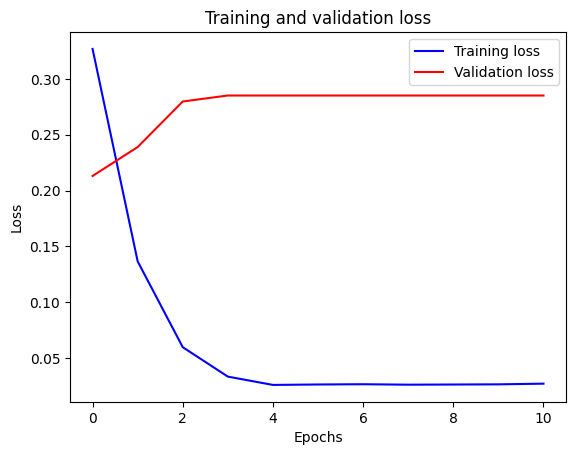

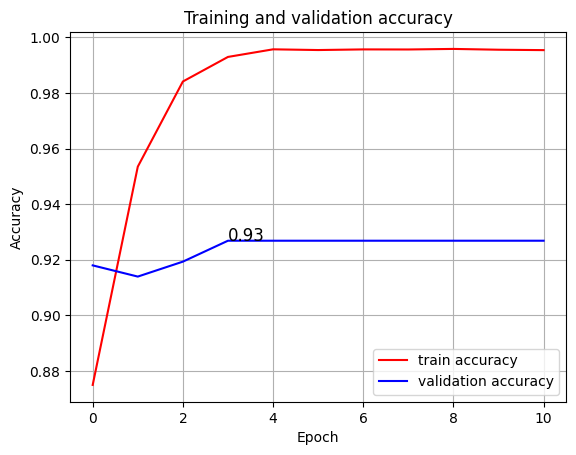

In [146]:
import matplotlib.pyplot as plt

train_loss = history["train_losses"]
val_loss = history["val_losses"]


# Plotting the training and validation loss
def plot_loss_fun_graph(train_loss, val_loss):
    plt.plot(train_loss, "b", label="Training loss")
    plt.plot(val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
plot_loss_fun_graph(train_loss, val_loss)

# Plotting the training and validation accuracy
train_acc = history["train_accuracies"]
val_acc = history["val_accuracies"]


# Encontrar o índice do melhor valor de acurácia de validação
def plot_accurary_graph(train_acc, val_acc):
    best_epoch = np.argmax(val_acc)
    best_accuracy = val_acc[best_epoch]
    plt.clf()
    plt.plot(train_acc, "r", label="train accuracy")
    plt.plot(val_acc, "b", label="validation accuracy")
    # Adicionar texto para destacar o melhor valor de acurácia de validação
    plt.text(
        best_epoch,
        best_accuracy,
        f"{best_accuracy:.2f}",
        fontsize=12,
        ha="left",
    )
    plt.title("Training and validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()


plot_accurary_graph(train_acc, val_acc)

### Get predicitons in test_texts and test_labels

In [228]:
def get_predictions(model, data_loader,device):
    model = model.eval()

    # outputs corresponde a saida do modelo
    outputs=[]
    # corresponde ao indice(classe) com maior probabilidade na saída do modelo
    predictions = []
    # corresponde a probabilidade de predicao
    predictions_prob = []
    # corresponde ao indice real(classe verdadeira)
    real_values = []
    

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            m_output = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(m_output, dim=1)
            
            max_value, max_index = torch.max(probs, dim=1)


            # review_texts.extend(texts)
            outputs.extend(probs)
            predictions.extend(max_index)
            predictions_prob.extend(max_value)
            real_values.extend(labels)
    outputs = torch.stack(outputs).cpu()
    predictions = torch.stack(predictions).cpu()
    predictions_prob = torch.stack(predictions_prob).cpu()
    real_values = torch.stack(real_values).cpu()
    return outputs, predictions, predictions_prob, real_values

In [230]:
#  CArregando com o modelo final atualizado
test_outputs, test_predictions, test_pred_probs, test_real_values=get_predictions(model,test_dataloader,device)

100%|██████████| 5552/5552 [30:32<00:00,  3.03it/s]   


In [257]:
classes_names = ["negativo", "positivo"]
test_report = classification_report(
    test_predictions, test_real_values, target_names=classes_names, output_dict=True
)
print(
    classification_report(
        test_predictions, test_real_values, target_names=classes_names
    )
)

              precision    recall  f1-score   support

    negativo       0.72      0.82      0.77     17465
    positivo       0.87      0.79      0.83     26945

    accuracy                           0.80     44410
   macro avg       0.79      0.81      0.80     44410
weighted avg       0.81      0.80      0.80     44410



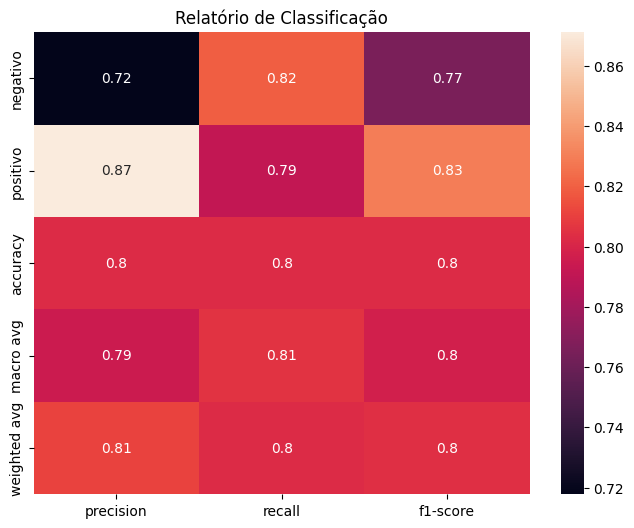

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_report(classification_report):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)
    plt.title("Relatório de Classificação")
    plt.show()


show_report(test_report)

É possível identificar com o report dos dados de teste que o modelo atingiu uma precião de 79% a 81%.

E que a precisão nos dados positivos foi maior, ocorrido pela quantidade de dados maior 

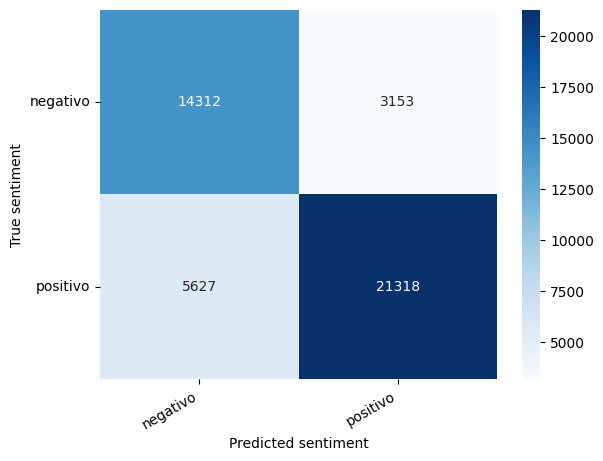

In [232]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
classes_names = ['negativo','positivo']  
cm = confusion_matrix(test_predictions,test_real_values)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)
# cm_display = ConfusionMatrixDisplay(cm,display_labels=classes_names).plot()


Conclui-se através da matriz de confusão e do report, que o modelo conseguiu aprender durante as epocas, e que a incidência de classificações verdadeiros_positivo e verdadeiro_negativo foram corespondentes a 80% nas duas classes

In [235]:
print(test_outputs)
print(test_predictions)
print(test_pred_probs)
print(test_real_values)

tensor([[0.0955, 0.9034, 0.0011],
        [0.0059, 0.9926, 0.0014],
        [0.0063, 0.9923, 0.0014],
        ...,
        [0.0062, 0.9924, 0.0014],
        [0.0059, 0.9927, 0.0015],
        [0.5892, 0.4096, 0.0012]])
tensor([1, 1, 1,  ..., 1, 1, 0])
tensor([0.9034, 0.9926, 0.9923,  ..., 0.9924, 0.9927, 0.5892])
tensor([1, 1, 1,  ..., 1, 1, 0])


In [ ]:
test-ou

In [236]:
df_predction_prob = pd.DataFrame(
    {
        "classes_prediction": test_predictions, # [0,1]
        "real_classe": test_real_values, #[0,1]
        "probabilidade": test_pred_probs,#[0 a 1]
    }
)

In [237]:
df_predction_prob

,classes_prediction,real_classe,probabilidade
0,1,1,0.903395
1,1,1,0.992622
2,1,1,0.992317
3,0,0,0.689169
4,0,0,0.991475
...,...,...,...
44405,1,1,0.980538
44406,0,0,0.996321
44407,1,1,0.992421
44408,1,1,0.992660


In [239]:
unique_classes = np.unique(test_predictions)
unique_classes

array([0, 1], dtype=int64)

In [241]:

mean_probs = [
    np.mean([p for pred, p in zip(test_predictions, test_pred_probs) if pred == cls])
    for cls in unique_classes
]
mean_probs

[0.9447653, 0.9623413]

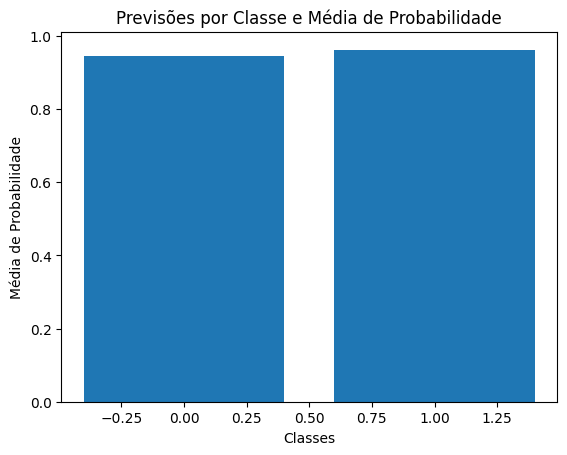

In [242]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que 'test_predictions' seja a sua lista de previsões e 'test_pred_probs' seja a lista de probabilidades
# test_predictions = ...
# test_pred_probs = ...

# Calcular a média de probabilidade para cada class

# Criar o gráfico de barras
plt.bar(unique_classes, mean_probs)
plt.xlabel("Classes")
plt.ylabel("Média de Probabilidade")
plt.title("Previsões por Classe e Média de Probabilidade")
plt.show()

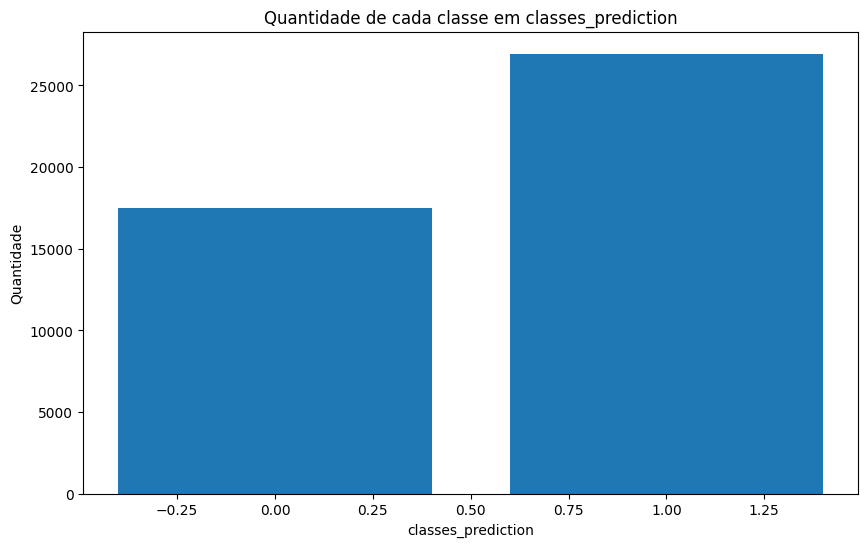

In [247]:
import matplotlib.pyplot as plt

# Conta a quantidade de cada classe em classes_prediction
counts = df_predction_prob['classes_prediction'].value_counts()

# Cria um gráfico de barras para mostrar a quantidade de cada classe
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.title('Quantidade de cada classe em classes_prediction')
plt.xlabel('classes_prediction')
plt.ylabel('Quantidade')
plt.show()


## Prediction sentiment in data web scraping(testing model )

Testando o modelo nos dados do scraper, dados que o modelo não viu duranto o treinamento,
validação e testes realizados acima. Devemos observar o resultado nos novos dados e julgar
se são adequados para serem colocados em produção

In [150]:
DATA_PATH = "D:/tcc2/guilherme/3_Data_Processing/data/Scraper_Dataset_tretead_text.csv"
df = pd.read_csv(DATA_PATH)
df = df[['review','rating']]
df


,review,rating
0,movie takes place fantasy land absolutely ridi...,1
1,sentimental pathetic slow conventionally voice...,1
2,things life understand universe begin happens ...,1
3,movie inspired brilliant stir crazy starring g...,1
4,life understand gushing cornball sentimental p...,1
...,...,...
44405,uma thurman returns bride time looks continue ...,10
44406,quentin tarantino kill bill vol 2 completes 2 ...,10
44407,vol 2 completely different tone features film ...,10
44408,movie great mixes different genres movies mart...,10


In [151]:
# # Para Classe Positivo[7,8,9,10] e Negativo [...]
def categorize_rating(rating):
    if int(rating) <= 6:
        return 0
    else:
        return 1

In [152]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["rating"].tolist()
    return texts, labels

In [153]:
df['rating'] = df['rating'].apply(categorize_rating)



In [154]:
print(df['rating'].value_counts())

rating
1    24471
0    19939
Name: count, dtype: int64


In [155]:
test_texts, test_labels = load_texts_labels(df)


In [156]:

test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [157]:
def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            # review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [158]:
predictions,prediction_probs,real_values = get_predictions(model, test_dataloader)
print(classification_report(predictions,real_values))

100%|██████████| 5552/5552 [11:04<00:00,  8.36it/s]


              precision    recall  f1-score   support

           0       0.72      0.82      0.77     17465
           1       0.87      0.79      0.83     26945

    accuracy                           0.80     44410
   macro avg       0.79      0.81      0.80     44410
weighted avg       0.81      0.80      0.80     44410



In [159]:
print(accuracy_score(predictions,real_values))

0.8022967800045034


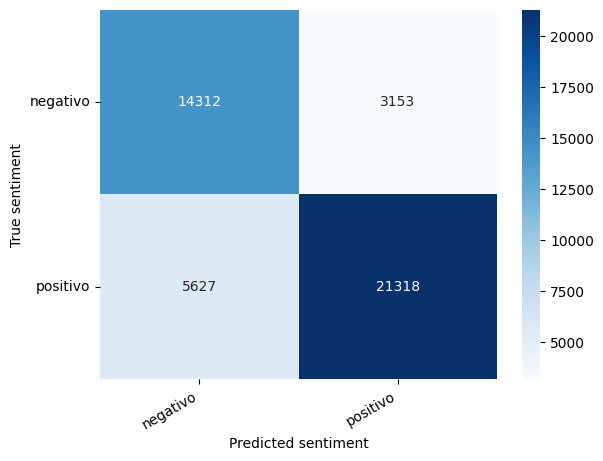

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
classes_names = ['negativo','positivo']  
cm = confusion_matrix(predictions,real_values)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)
# cm_display = ConfusionMatrixDisplay(cm,display_labels=classes_names).plot()


In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [161]:
def predict_tratamento_texto(text: str, lemma:bool):
    nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(re.compile("<.*?>"), "", text)
    doc = nlp(text)
    if lemma == True:
        text = " ".join(
            [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        )  # retorna o lemma
    else:
        text = " ".join(
            [token.text for token in doc if not token.is_stop and not token.is_punct]
        )  # return text
    return text



In [179]:
def predict_sentiment(
    text: str,
    model: MultiClassClassifier,
    tokenizer: BertTokenizer,
    device: str,
    max_length: int,
):
    model.eval()
    text = predict_tratamento_texto(text, lemma=False)
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = F.softmax(outputs, dim=1)

    prob_neg = prob[0, 0].item()
    prob_pos = prob[0, 1].item()
    print(f"prob negativa: {prob_neg:.5f}")
    print(f"prob positiva: {prob_pos:.5f}")

    prob_acept = 0.75
    if prob_neg >= prob_acept:
        return "negative"
    elif prob_pos >= prob_acept:
        return "positive"
    else:
        return "neutral"

In [180]:
# Capita marvel 2019 5/10
text = """
    Plot

Carol Danvers     becomes one of the universe's most powerful heroes when Earth is caught in the middle of a galactic war between two alien races.

Cast

Brie Larson, Samuel L. Jackson (Because duh), Jude "Just consistently dreadful" Law, Annette Bening, Djimon Hounsou, Clark Gregg and blink and you'll miss him Lee Pace who returns as Ronan but looks so different I didn't even think it was him.

Verdict

I watched this back when it was initially released, I watched it a second time a few days ago as the missus is wanting us to binge watch the entire MCU as she's very behind. My opinion has changed on the 2nd viewing and not in a good way, my rating has shifted from a 6/10 to 5/10.

You see straight out of the gate the first thing you notice about Carol Danvers is she's not really a character you can get behind. She's not funny, she's not entertaining, she comes across as a surly teenage girl who is just upset at the slightest thing and just doesn't want to be there. This is not a character you can build a movie around, like trying to make a teenage Groot movie! It wouldn't work, but he's okay as a side character.

Supporting cast are also hit and miss, Jackson and Gregg are great, but Lynch and Law just stink up every scene they're in.

I'm a Marvel fan but I recognize where it's weak, this is a distinctly average film that serves as a standalone origin story and doesn't contribute much to the universe as a whole.

Rants

I remember when the movie came out all the controversy with Brie Larson, I just had to Google what the controversy even was as I don't remember due to not focusing on such things. Now I can't really get a definitive answer. From what I see it's a combination of people not liking her attitude and her comments on feminism. So I Googled further to see what she said, she came across arrogant in them and a smidge out of touch but none of it explained the overwhelming hate I've seen aimed at her. Then I remembered that people talk about all the different types of bigotry but misogyny rarely comes up, I remembered that it's visibly increased over the past decade and appreciated why she's been targeted. News flash, the outspoken loud brash man hating femnists you likely thing of when you hear that word make up a very small percentage. Feminism is good, if you disagree I hope you simply don't know the meaning of the word.

The Good

Jackson and Gregg Has a couple of decent moments Not a bad soundtrack Goose!

The Bad

Larson isn't great Law and Lynch are terrible Lead just comes across unlikable.

Overall just a weak entry to the MC
"""

In [181]:
# Test sentiment prediction
# test_text = " very perfect very good very bad bad well, "
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
# sentiment2 = predict_sentiment(text, saved_model, tokenizer, device, max_length)

print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")
# print(f"Predicted sentiment: {sentiment2}")

prob negativa: 0.99602
prob positiva: 0.00369
plot carol danvers universe powerful heroes earth caught middle galactic war alien races cast brie larson samuel l. jackson duh jude consistently dreadful law annette bening djimon hounsou clark gregg blink miss lee pace returns ronan looks different think verdict watched initially released watched second time days ago missus wanting binge watch entire mcu opinion changed 2nd viewing good way rating shifted 6/10 5/10 straight gate thing notice carol danvers character funny entertaining comes surly teenage girl upset slightest thing want character build movie like trying teenage groot movie work okay character supporting cast hit miss jackson gregg great lynch law stink scene marvel fan recognize weak distinctly average film serves standalone origin story contribute universe rants remember movie came controversy brie larson google controversy remember focusing things definitive answer combination people liking attitude comments feminism goog

In [182]:
# CApita marvel 2019 6/10
text="""Mediocre Marvel is still pretty good.

My first review in a long time! Dont know why I decided to write about this movie.

I agree with most mediocre reviews I read here.

The pacing was pretty good.

Most of the action was good!

The story was ok and had some good twists.

I thought about giving this movie a 6 but after letting it sink in I decided to give it 8 out of 10

It entertained me and my company from beginning to end.

There were some eye rolling moments but they are easily forgiven."""

In [183]:
# Test sentiment prediction
# test_text = " very perfect very good very bad bad well, "
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
# sentiment2 = predict_sentiment(text, saved_model, tokenizer, device, max_length)

print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")
# print(f"Predicted sentiment: {sentiment2}")

prob negativa: 0.00612
prob positiva: 0.99249
mediocre marvel pretty good review long time nt know decided write movie agree mediocre reviews read pacing pretty good action good story ok good twists thought giving movie 6 letting sink decided 8 10 entertained company beginning end eye rolling moments easily forgiven
Predicted sentiment: positive


In [184]:
# Test sentiment prediction
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Texto: ", test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.99634
prob positiva: 0.00336
Texto:  The movie was so bad and I would not recommend it to anyone.
Predicted sentiment: negative


In [185]:
# Test sentiment prediction
test_text = "Best movie of the year. "
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Worst movie of the year.")
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.00591
prob positiva: 0.99257
Worst movie of the year.
Predicted sentiment: positive


In [186]:
# Test sentiment prediction
test_text = "This movie is more or less very hungry"
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.86379
prob positiva: 0.13521
This movie is more or less very hungry
Predicted sentiment: negative
